1: Import thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from datetime import datetime

# Đặt seed ngẫu nhiên
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cpu


2: Đọc dữ liệu

In [3]:
# Đọc dữ liệu
df = pd.read_csv('D:\TunTun\HTTT2022.2\IS403.P23-Gold\Dataset\gold_price.csv')

# Hiển thị thông tin dữ liệu
print(df.info())
print("\nMẫu dữ liệu:")
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      3886 non-null   object
 1   Price     3886 non-null   object
 2   Open      3886 non-null   object
 3   High      3886 non-null   object
 4   Low       3886 non-null   object
 5   Vol.      3883 non-null   object
 6   Change %  3886 non-null   object
dtypes: object(7)
memory usage: 212.6+ KB
None

Mẫu dữ liệu:
         Date     Price      Open      High       Low     Vol. Change %
0  04/01/2025  3,146.00  3,157.30  3,177.00  3,130.50  197.31K   -0.14%
1  03/31/2025  3,150.30  3,118.80  3,162.00  3,112.40  228.39K    1.16%
2  03/28/2025  3,114.30  3,099.30  3,124.40  3,096.30  210.49K    1.25%
3  03/27/2025  3,075.80  3,040.90  3,086.00  3,038.90    2.86K    1.27%
4  03/26/2025  3,037.30  3,039.50  3,049.70  3,032.80    1.68K   -0.08%


<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Admin\AppData\Local\Temp\ipykernel_28524\1577158857.py:2: SyntaxWarning: invalid escape sequence '\T'
  df = pd.read_csv('D:\TunTun\HTTT2022.2\IS403.P23-Gold\Dataset\gold_price.csv')


3: Tiền xử lý dữ liệu

In [4]:
# Tiền xử lý dữ liệu
df['Date'] = pd.to_datetime(df['Date'])

# Xử lý các cột số
for col in ['Price', 'Open', 'High', 'Low']:
    if df[col].dtype == 'object':  # Nếu là kiểu object (chuỗi)
        df[col] = df[col].str.replace('$', '', regex=True)
        df[col] = df[col].str.replace(',', '', regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Xử lý cột 'Vol.'
if 'Vol.' in df.columns:
    df['Vol.'] = df['Vol.'].astype(str).replace('', np.nan)
    df['Vol.'] = df['Vol.'].apply(lambda x: float(str(x).replace('K', '')) * 1000 if pd.notna(x) and isinstance(x, str) and 'K' in x else x)
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
    df['Vol.'] = df['Vol.'].fillna(df['Vol.'].mean())

# Xử lý cột 'Change %'
if 'Change %' in df.columns:
    if df['Change %'].dtype == 'object':
        df['Change %'] = df['Change %'].str.replace('%', '', regex=True)
        df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce') / 100

# Sắp xếp dữ liệu từ cũ đến mới
df = df.sort_values('Date').reset_index(drop=True)

# Hiển thị dữ liệu sau khi xử lý
print("\nDữ liệu sau khi xử lý:")
print(df.head())


Dữ liệu sau khi xử lý:
        Date   Price    Open    High     Low      Vol.  Change %
0 2010-01-04  1118.3  1099.0  1124.6  1093.8  155480.0    0.0202
1 2010-01-05  1118.7  1122.0  1129.6  1115.5  156410.0    0.0004
2 2010-01-06  1136.5  1118.5  1141.0  1116.8  176900.0    0.0159
3 2010-01-07  1133.7  1139.0  1139.5  1128.7  121150.0   -0.0025
4 2010-01-08  1138.9  1131.5  1140.0  1119.5  212620.0    0.0046


4: Chuẩn bị dữ liệu với StandardScaler

In [7]:
# Chọn các đặc trưng đầu vào
features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
data = df[features].values

# Sử dụng StandardScaler thay vì MinMaxScaler theo yêu cầu
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Lưu scaler riêng cho giá để sử dụng khi dự đoán
price_scaler = StandardScaler()
price_data = df[['Price']].values
price_scaler.fit_transform(price_data)

# Chia tập dữ liệu train-validation-test theo tỉ lệ 60:20:20
total_samples = len(scaled_data)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size+val_size]
test_data = scaled_data[train_size+val_size:]

print(f"Kích thước tập huấn luyện: {train_data.shape}")
print(f"Kích thước tập validation: {val_data.shape}")
print(f"Kích thước tập kiểm tra: {test_data.shape}")

Kích thước tập huấn luyện: (2720, 6)
Kích thước tập validation: (582, 6)
Kích thước tập kiểm tra: (584, 6)


5: Tạo bộ dữ liệu chuỗi thời gian với time_step = 90

In [8]:
# Hàm tạo bộ dữ liệu chuỗi thời gian
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])  # Lấy tất cả đặc trưng
        y.append(data[i + time_step, 0])  # Chỉ dự đoán giá (Price)
    return np.array(X), np.array(y)

# Sử dụng time_step=90 theo yêu cầu
time_step = 90
print(f"Sử dụng time_step = {time_step}")

# Tạo chuỗi thời gian cho tập train, validation và test
X_train, y_train = create_sequences(train_data, time_step)
X_val, y_val = create_sequences(val_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Chuyển đổi dữ liệu sang torch tensor
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1)).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val.reshape(-1, 1)).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test.reshape(-1, 1)).to(device)

print(f"Kích thước X_train: {X_train.shape}")
print(f"Kích thước X_val: {X_val.shape}")
print(f"Kích thước X_test: {X_test.shape}")

Sử dụng time_step = 90
Kích thước X_train: (2630, 90, 6)
Kích thước X_val: (492, 90, 6)
Kích thước X_test: (494, 90, 6)


6: Định nghĩa mô hình GRU

In [9]:
# Định nghĩa mô hình GRU
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Thêm lớp dropout như cách cải thiện
        self.dropout = nn.Dropout(0.2)
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, 
                          num_layers=num_layers, batch_first=True, dropout=0.2 if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.gru(x, h0)
        out = self.dropout(out[:, -1, :])  # Apply dropout to the last output
        out = self.fc(out)
        return out

# Số đặc trưng đầu vào
input_dim = len(features)

# Khởi tạo mô hình
model = GRUModel(input_dim=input_dim, hidden_dim=64, num_layers=2).to(device)
print(model)

GRUModel(
  (dropout): Dropout(p=0.2, inplace=False)
  (gru): GRU(6, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


7: Huấn luyện mô hình với Early Stopping

In [10]:
# Định nghĩa loss function và optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình với early stopping
num_epochs = 200  # Tăng số epoch tối đa
batch_size = 32
train_losses = []
val_losses = []

# Tham số cho early stopping
patience = 10
min_delta = 0.001  # Tương đương với early stopping = 0.1%
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print("Bắt đầu huấn luyện...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    # Mini-batch training
    permutation = torch.randperm(X_train_tensor.size(0))
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(indices)
    
    avg_train_loss = total_loss / len(X_train_tensor)
    train_losses.append(avg_train_loss)
    
    # Đánh giá trên tập validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_losses.append(val_loss)
    
    # In thông tin mỗi 10 epoch
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    # Early stopping check
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f'Epoch {epoch+1}: Cải thiện validation loss -> {val_loss:.6f}')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping tại epoch {epoch+1}')
            break

# Tải lại trọng số tốt nhất nếu đã lưu
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Đã tải trọng số tốt nhất cho mô hình")

Bắt đầu huấn luyện...
Epoch 1: Cải thiện validation loss -> 0.003273
Epoch 4: Cải thiện validation loss -> 0.002137
Epoch [10/200], Train Loss: 0.004213, Val Loss: 0.004799
Early stopping tại epoch 14
Đã tải trọng số tốt nhất cho mô hình


8: Vẽ biểu đồ loss

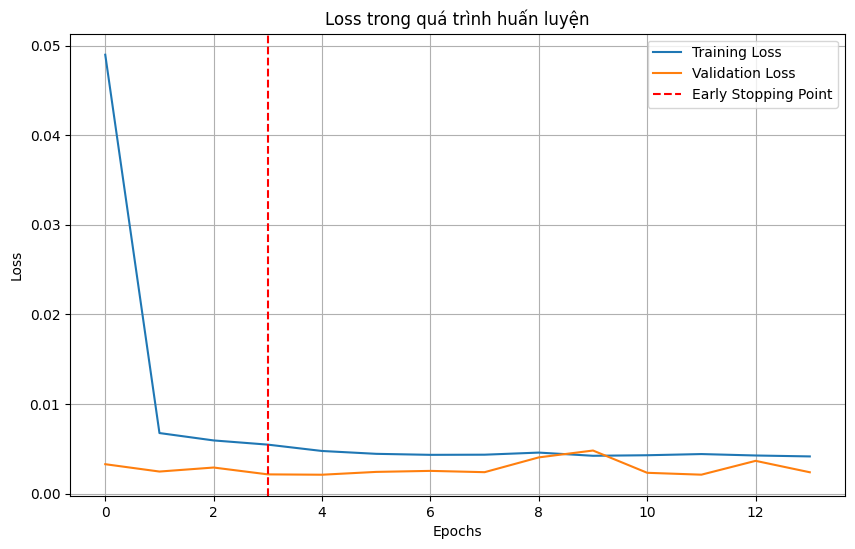

In [11]:
# Vẽ biểu đồ loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axvline(x=len(val_losses)-patience-1, color='r', linestyle='--', label='Early Stopping Point')
plt.title('Loss trong quá trình huấn luyện')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

9: Đánh giá mô hình với các phương pháp đánh giá

In [12]:
# Đánh giá mô hình trên tập test
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()
    y_val_pred = model(X_val_tensor).cpu().numpy()
    y_train_pred = model(X_train_tensor).cpu().numpy()

# Chuyển đổi giá trị dự đoán và thực tế về thang đo ban đầu
y_train_actual = price_scaler.inverse_transform(y_train_tensor.cpu().numpy())
y_train_pred = price_scaler.inverse_transform(y_train_pred)

y_val_actual = price_scaler.inverse_transform(y_val_tensor.cpu().numpy())
y_val_pred = price_scaler.inverse_transform(y_val_pred)

y_test_actual = price_scaler.inverse_transform(y_test_tensor.cpu().numpy())
y_test_pred = price_scaler.inverse_transform(y_test_pred)

# Hàm tính MASE (Mean Absolute Scaled Error)
def calculate_mase(y_true, y_pred, y_train):
    """
    Tính MASE (Mean Absolute Scaled Error)
    MASE = MAE / MAE_naïve
    Trong đó, MAE_naïve là MAE của mô hình naïve (dự đoán = giá trị trước đó)
    """
    mae = mean_absolute_error(y_true, y_pred)
    
    # Tính sai số của mô hình naïve (dự đoán = giá trị kề trước)
    naive_errors = []
    for i in range(1, len(y_train)):
        naive_errors.append(abs(y_train[i] - y_train[i-1]))
    
    mae_naive = np.mean(naive_errors)
    
    # Tránh chia cho 0
    if mae_naive == 0:
        return np.inf
    
    return mae / mae_naive

# Đánh giá trên tập test
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
test_mae = mean_absolute_error(y_test_actual, y_test_pred)
test_mape = np.mean(np.abs((y_test_actual - y_test_pred) / y_test_actual)) * 100
test_mase = calculate_mase(y_test_actual, y_test_pred, y_train_actual)

# In kết quả đánh giá
print("\n--- Đánh giá mô hình ---")
print(f"RMSE (Root Mean Square Error): {test_rmse:.2f}")
print(f"MAE (Mean Absolute Error): {test_mae:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {test_mape:.2f}%")
print(f"MASE (Mean Absolute Scaled Error): {test_mase:.4f}")


--- Đánh giá mô hình ---
RMSE (Root Mean Square Error): 220.27
MAE (Mean Absolute Error): 149.87
MAPE (Mean Absolute Percentage Error): 5.70%
MASE (Mean Absolute Scaled Error): 14.9773


10: Dự đoán tương lai

In [13]:
# Hàm dự báo tương lai
def predict_future(model, last_sequence, n_future=90):  # Thay đổi từ 30 thành 90 ngày
    model.eval()
    future_predictions = []
    
    # Tạo bản sao của chuỗi cuối cùng
    curr_seq = torch.FloatTensor(last_sequence).to(device)
    
    with torch.no_grad():
        for _ in range(n_future):
            # Thêm thêm chiều batch
            curr_seq_batch = curr_seq.unsqueeze(0)
            # Dự đoán
            pred = model(curr_seq_batch)
            # Lấy giá trị dự đoán
            next_pred = pred.item()
            future_predictions.append(next_pred)
            
            # Chuẩn bị cho bước tiếp theo
            last_row = curr_seq[-1].clone()
            last_row[0] = next_pred
            curr_seq = torch.cat([curr_seq[1:], last_row.unsqueeze(0)])
    
    return np.array(future_predictions).reshape(-1, 1)

# Dự đoán 90 ngày tương lai
last_sequence = scaled_data[-time_step:]
future_pred_scaled = predict_future(model, last_sequence, 90)  # Thay đổi thành 90 ngày
future_pred = price_scaler.inverse_transform(future_pred_scaled)

# Ngày cho dự đoán tương lai
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)  # Thay đổi thành 90 ngày

11: Vẽ biểu đồ kết quả

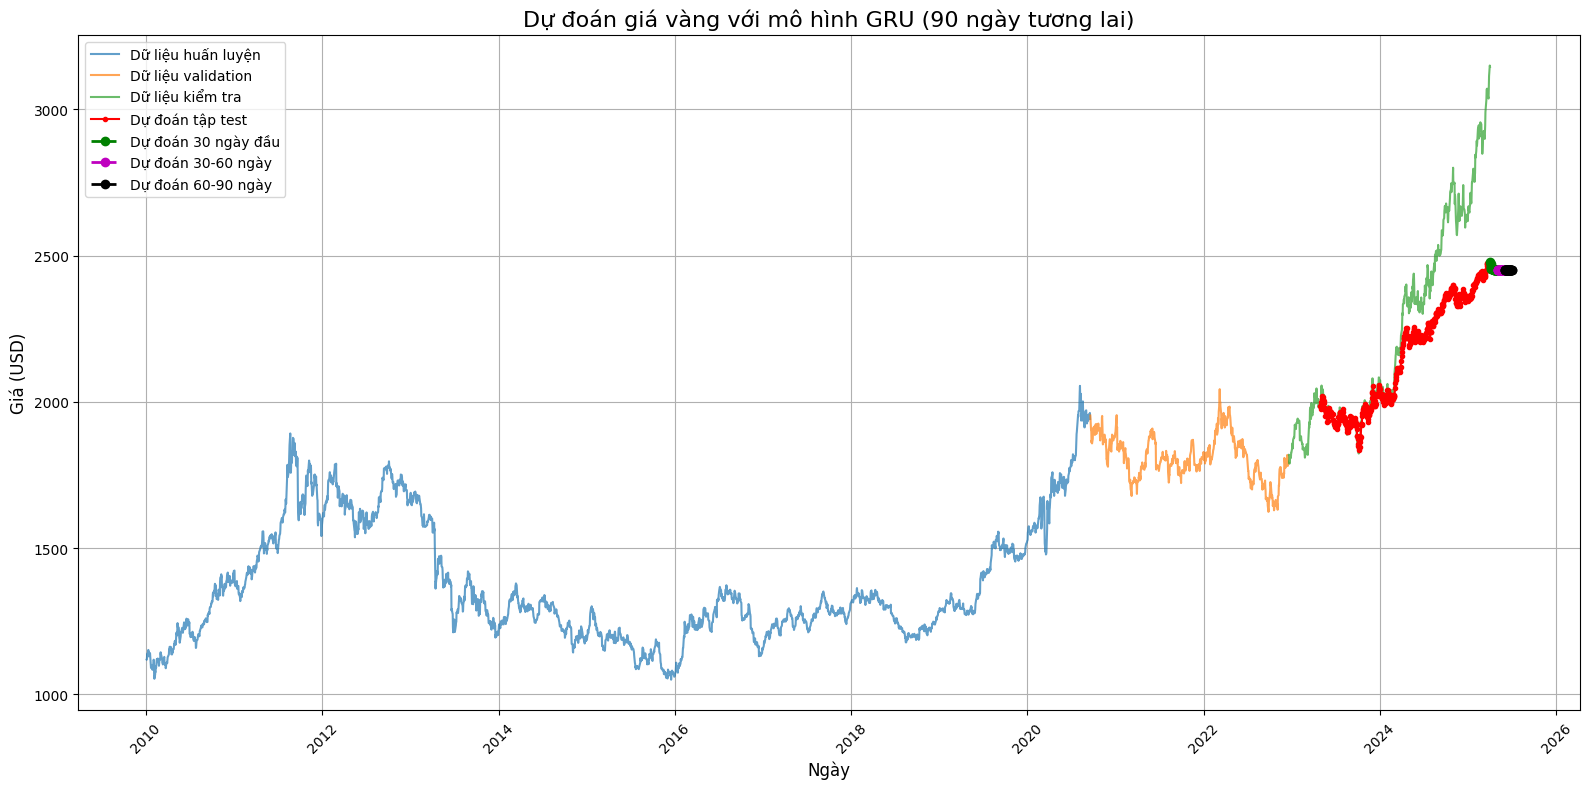

In [14]:
# Vẽ biểu đồ kết quả
plt.figure(figsize=(16, 8))

# Dữ liệu thực tế
train_end = train_size
val_end = train_size + val_size

plt.plot(df['Date'][:train_end], price_data[:train_end], label='Dữ liệu huấn luyện', alpha=0.7)
plt.plot(df['Date'][train_end:val_end], price_data[train_end:val_end], label='Dữ liệu validation', alpha=0.7)
plt.plot(df['Date'][val_end:], price_data[val_end:], label='Dữ liệu kiểm tra', alpha=0.7)

# Đảm bảo kích thước phù hợp cho dự đoán
test_dates = df['Date'][val_end+time_step:min(val_end+time_step+len(y_test_pred), len(df))]
test_pred_to_plot = y_test_pred[:len(test_dates)]

plt.plot(test_dates, test_pred_to_plot, 'ro-', label='Dự đoán tập test', markersize=3)

# Chia dự đoán tương lai thành 3 giai đoạn (30 ngày mỗi giai đoạn)
plt.plot(future_dates[:30], future_pred[:30], 'go--', label='Dự đoán 30 ngày đầu', linewidth=2)
plt.plot(future_dates[30:60], future_pred[30:60], 'mo--', label='Dự đoán 30-60 ngày', linewidth=2)
plt.plot(future_dates[60:], future_pred[60:], 'ko--', label='Dự đoán 60-90 ngày', linewidth=2)

plt.title('Dự đoán giá vàng với mô hình GRU (90 ngày tương lai)', fontsize=16)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

12: Hiển thị dự đoán tương lai

In [15]:
# Tính độ chính xác của mô hình
accuracy = 100 - test_mape  # Độ chính xác = 100% - MAPE
print(f"\n--- Độ chính xác của mô hình ---")
print(f"Độ chính xác dựa trên MAPE: {accuracy:.2f}%")
print(f"Sai số trung bình (MAPE): {test_mape:.2f}%")
print(f"RMSE: {test_rmse:.2f} USD")
print(f"MAE: {test_mae:.2f} USD")
print(f"MASE: {test_mase:.4f} {'(Tốt hơn dự đoán naive)' if test_mase < 1 else '(Kém hơn dự đoán naive)'}")

# In dự đoán giá vàng 90 ngày tương lai
print("\n=== DỰ ĐOÁN GIÁ VÀNG 90 NGÀY TƯƠNG LAI ===")

# In dự đoán chi tiết theo từng tháng
print("\n-- 30 NGÀY ĐẦU TIÊN --")
for i in range(30):
    print(f"{future_dates[i].strftime('%Y-%m-%d')}: ${future_pred[i][0]:.2f}")

print("\n-- 30 NGÀY TIẾP THEO --")
for i in range(30, 60):
    print(f"{future_dates[i].strftime('%Y-%m-%d')}: ${future_pred[i][0]:.2f}")

print("\n-- 30 NGÀY CUỐI --")
for i in range(60, 90):
    print(f"{future_dates[i].strftime('%Y-%m-%d')}: ${future_pred[i][0]:.2f}")

# So sánh với giá hiện tại
current_price = df['Price'].iloc[-1]
next_day_price = future_pred[0][0]
price_change = ((next_day_price - current_price) / current_price) * 100

print(f"\nGiá hiện tại: ${current_price:.2f}")
print(f"Giá dự đoán ngày tiếp theo: ${next_day_price:.2f}")
print(f"Biến động dự kiến: {price_change:.2f}%")

if price_change > 0:
    print("Dự đoán: Giá sẽ TĂNG ↑")
else:
    print("Dự đoán: Giá sẽ GIẢM ↓")

# Phân tích xu hướng dài hạn
long_term_trend = ((future_pred[-1][0] - current_price) / current_price) * 100
print(f"\nXu hướng 90 ngày: {long_term_trend:.2f}%")
if long_term_trend > 0:
    print("Dự đoán xu hướng dài hạn: TĂNG ↑")
else:
    print("Dự đoán xu hướng dài hạn: GIẢM ↓")


--- Độ chính xác của mô hình ---
Độ chính xác dựa trên MAPE: 94.30%
Sai số trung bình (MAPE): 5.70%
RMSE: 220.27 USD
MAE: 149.87 USD
MASE: 14.9773 (Kém hơn dự đoán naive)

=== DỰ ĐOÁN GIÁ VÀNG 90 NGÀY TƯƠNG LAI ===

-- 30 NGÀY ĐẦU TIÊN --
2025-04-02: $2479.81
2025-04-03: $2470.62
2025-04-04: $2464.20
2025-04-05: $2459.93
2025-04-06: $2457.65
2025-04-07: $2456.07
2025-04-08: $2455.03
2025-04-09: $2454.30
2025-04-10: $2453.92
2025-04-11: $2453.56
2025-04-12: $2453.25
2025-04-13: $2453.17
2025-04-14: $2453.03
2025-04-15: $2452.87
2025-04-16: $2452.69
2025-04-17: $2452.42
2025-04-18: $2452.42
2025-04-19: $2452.44
2025-04-20: $2452.38
2025-04-21: $2452.34
2025-04-22: $2452.28
2025-04-23: $2452.44
2025-04-24: $2452.23
2025-04-25: $2452.28
2025-04-26: $2452.26
2025-04-27: $2452.16
2025-04-28: $2452.30
2025-04-29: $2452.32
2025-04-30: $2452.27
2025-05-01: $2452.08

-- 30 NGÀY TIẾP THEO --
2025-05-02: $2452.14
2025-05-03: $2452.17
2025-05-04: $2452.09
2025-05-05: $2452.05
2025-05-06: $2452.05
